In [2]:
!pip uninstall Pillow -y
!pip install Pillow==6.2.1 torchvision==0.4.0 sklearn opencv-python moviepy

Found existing installation: Pillow 6.2.1
Uninstalling Pillow-6.2.1:
  Successfully uninstalled Pillow-6.2.1
  Using cached Pillow-6.2.1-cp37-cp37m-manylinux1_x86_64.whl (2.1 MB)
ERROR: datalab 1.1.5 has requirement pandas-profiling==1.4.0, but you'll have pandas-profiling 2.4.0 which is incompatible.


In [56]:
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import torch
import re
from moviepy.editor import *
import cv2
import numpy as np
import os

# Playing video from file:
cap = cv2.VideoCapture('test.webm')

try:
    if not os.path.exists('data'):
        os.makedirs('data')
except OSError:
    print ('Error: Creating directory of data')

currentFrame = 0


while(True):
    ret, frame = cap.read()

    name = './data/frame' + str(currentFrame) + '.jpg'
    print ('Creating...' + name)
    cv2.imwrite(name, frame)

    currentFrame += 1

cap.release()
cv2.destroyAllWindows()

Creating..../data/frame0.jpg
Creating..../data/frame1.jpg
Creating..../data/frame2.jpg
Creating..../data/frame3.jpg
Creating..../data/frame4.jpg
Creating..../data/frame5.jpg
Creating..../data/frame6.jpg
Creating..../data/frame7.jpg
Creating..../data/frame8.jpg
Creating..../data/frame9.jpg
Creating..../data/frame10.jpg
Creating..../data/frame11.jpg
Creating..../data/frame12.jpg
Creating..../data/frame13.jpg
Creating..../data/frame14.jpg
Creating..../data/frame15.jpg
Creating..../data/frame16.jpg
Creating..../data/frame17.jpg
Creating..../data/frame18.jpg
Creating..../data/frame19.jpg
Creating..../data/frame20.jpg
Creating..../data/frame21.jpg
Creating..../data/frame22.jpg
Creating..../data/frame23.jpg
Creating..../data/frame24.jpg
Creating..../data/frame25.jpg
Creating..../data/frame26.jpg
Creating..../data/frame27.jpg
Creating..../data/frame28.jpg
Creating..../data/frame29.jpg
Creating..../data/frame30.jpg
Creating..../data/frame31.jpg
Creating..../data/frame32.jpg
Creating..../data/fr

error: OpenCV(4.2.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:715: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [22]:
from torchvision import models
import torchvision.transforms as T


dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

In [54]:
def decode_segmap(image, source, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  
  rgb = np.stack([r, g, b], axis=2)

  # Load the foreground input image 
  foreground = cv2.imread(source)

  # Change the color of foreground image to RGB 
  # and resize image to match shape of R-band in RGB output map
  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))

  # Create a background array to hold white pixels
  # with the same size as RGB output map
  background = 255 * np.ones_like(rgb).astype(np.uint8)

  # Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)

  # Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

  # Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)

  # Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255

  # Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)  
  
  # Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)  
  
  # Add the masked foreground and background
  outImage = cv2.add(foreground, background)

  # Return a normalized output image for display
  return outImage/255

def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(450), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  
  rgb = decode_segmap(om, path)
    
#   plt.imshow(rgb); plt.axis('off'); plt.show()
  return rgb

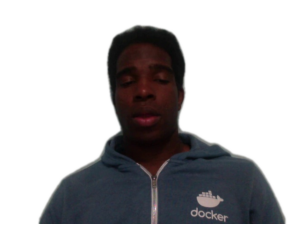

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [49]:
segment(dlab,'errolson_test.png',show_orig=False)


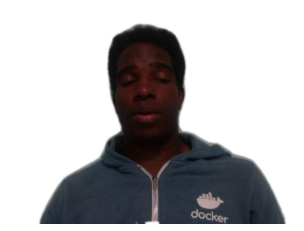

In [72]:
try:
    if not os.path.exists('bg_removed'):
        os.makedirs('bg_removed')
except OSError:
    print ('Error: Creating directory of data')
    
entries = os.listdir('./data/')
entries.sort(key=lambda f: int(re.sub('\D', '', f)))
for index,file in enumerate(entries):
    file =f"data/{file}"
    image = segment(dlab,file,show_orig=False)
    name = f"bg_removed/frame_bg_removed{index}.jpg"
#     print(image)
    plt.imshow(image)
    plt.axis('off')
    plt.savefig(name)

In [73]:
from glob import glob

def stitch_all_images(videos_path):
    img_array = []
    for filename in glob(f'{videos_path}*.jpg'):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)


    out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    
    


In [74]:
stitch_all_images('bg_removed/')



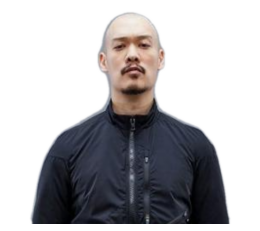

In [86]:
image = segment(dlab,'Errolson.jpg',show_orig=False)
plt.imshow(image)
plt.axis('off')
plt.savefig('Errolson_bg_removed.jpg')

## First order model preprocessing

Now that we have removed the background to focus on the details that we actually need  (the face and upper body), we need to resize this down to the point that the first order model can
    - 
- Link here at 